**Project Setup and Data Collection**

Environment Setup: Ensure *PyTorch* and other required libraries like NumPy, Pandas, Matplotlib, and OpenCV are installed in your Python environment.
Data Collection: The dataset should consist of lung scan images, preferably CT scans or X-rays, labeled as **COVID** or **Normal**. Public datasets like the **X-Ray Image Dataset For #COVID-19 Detection (A)** can be used.

**Explanation**
* **Transformations**: The images are resized to 224x224 pixels, converted to tensor format, and normalized. Normalization parameters (`mean` and `std`) are standard for models pre-trained on ImageNet.
* **Dataset Loading**: **`ImageFolder`** is used to load the dataset, automatically associating each folder with a class.
* **Train-Validation Split**: The dataset is split into training and validation sets, with 80% of the data used for training and 20% for validation.
* **DataLoaders**: Data loaders for both training and validation datasets are created to efficiently load data in batches during the training process.

In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the path to your dataset
dataset_path = "../input/xray-image-dataset-for-covid19-detection-a/Dataset_A"

# Define transformations
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # A simple augmentation
    transforms.RandomRotation(10),  # Rotates the image by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transformations)

# Splitting the dataset into training and validation sets
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Creating data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [2]:
len(train_loader), len(val_loader), len(test_loader)

(8, 3, 3)

**To ensure balanced sampling during training, let's proceed with the following steps:**

In [3]:
from collections import Counter

# Assuming `dataset` is your dataset loaded with torchvision.datasets.ImageFolder
class_counts = Counter(full_dataset.targets)
class_names = full_dataset.classes
print(class_counts)
# Convert counts to a list of counts, aligned with the order of class names
counts = [class_counts[i] for i in range(len(class_names))]

print(f'Number of images per each class: `COVID: {counts[0]} | NORMAL: {counts[1]}')

Counter({0: 196, 1: 196})
Number of images per each class: `COVID: 196 | NORMAL: 196


**Data Distribution:**

Plot the distribution of classes to check for imbalance.

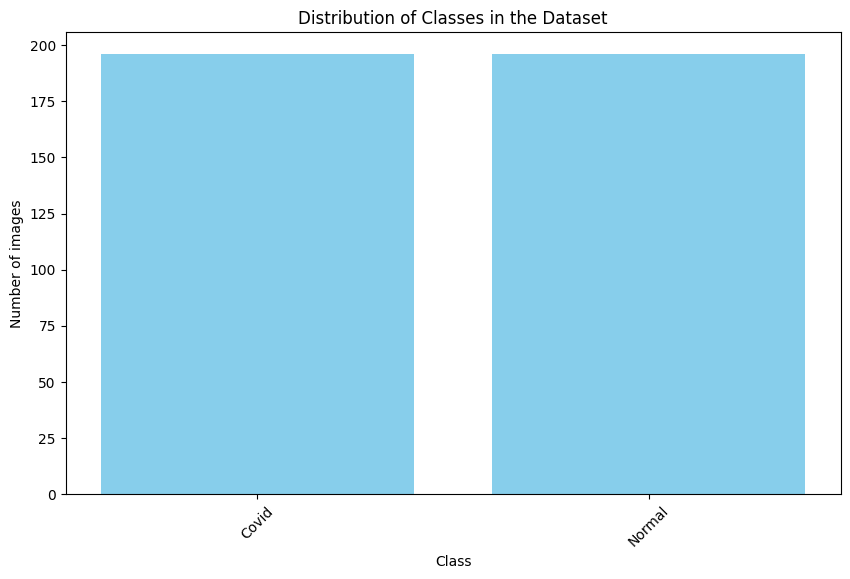

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')

plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of Classes in the Dataset')
plt.xticks(rotation=45)  # Rotate class names for better readability if necessary

plt.show()


**Data Visualization**

Visualizing the data is key to understanding the dataset's characteristics and ensuring that data preprocessing steps like resizing and normalization have been applied correctly.

Display Sample Images
Let's display a few images from each class (COVID and Normal) to visualize the preprocessing effects and augmentation:

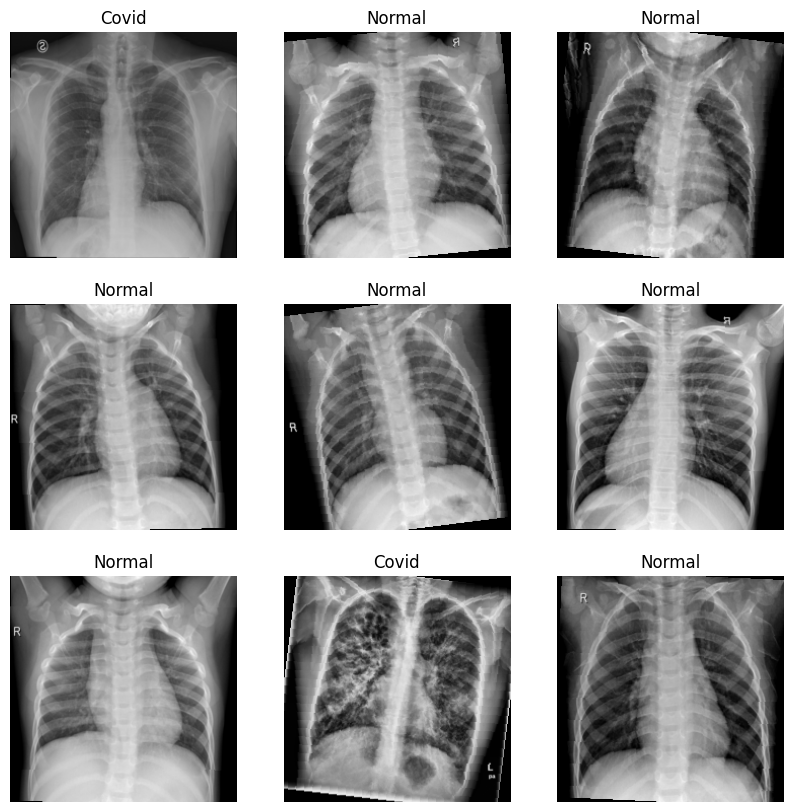

In [5]:
import matplotlib.pyplot as plt

def show_images(images, labels, classes):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        image = image.numpy().transpose((1, 2, 0))  # Convert from tensor image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = std * image + mean  # Unnormalize
        image = torch.clamp(image, 0, 1)
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(classes[label])
        plt.axis("off")
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))
show_images(images[:9], labels[:9], full_dataset.classes)


**NEXT STEP**

**Transfer Learning:** Leveraging a pre-trained model like `ResNet50` allows us to use the rich feature extractors learned from a large and general dataset (`ImageNet`). By retraining only the final layer, we can adapt these features to our specific task with relatively little data and computational resources.

**Custom Layers:** Modifying the final fully connected layer to output a single value allows us to perform binary classification. The model's output can be interpreted as the logit of the probability that an image is COVID-positive. Applying a `Sigmoid` function to this output (outside the model, during inference) would give the probability directly.

**Loss Function and Optimizer:** The choice of BCEWithLogitsLoss is suitable for binary classification problems with two class labels. The `Adam optimizer` is chosen for its adaptive learning rate properties, which can lead to faster convergence in training neural networks.

**Model Building Steps**

**1. Load Pre-trained `ResNet50` Model**

First, we import the necessary libraries and load a pre-trained `ResNet50` model. We'll freeze its layers to prevent them from being updated during the first phase of training.

In [6]:
import torchvision.models as models
import torch.nn as nn

# Load a pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze all the parameters in the model
for param in resnet50.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


**`resnet50` architecture**

To view the architecture of the modified ResNet50 model, including the changes made for binary classification, we can use the torchinfo library, which provides detailed information about PyTorch models. This includes the `layer types`, `input shape`, `output shapes`, and `parameter` counts, `trainable`.

In [7]:
from torchinfo import summary
col_names = ["input_size", "output_size", "num_params", "trainable",]
summary(resnet50, input_size=(1, 3, 244,244),col_names=col_names)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [1, 3, 244, 244]          [1, 1000]                 --                        False
├─Conv2d: 1-1                            [1, 3, 244, 244]          [1, 64, 122, 122]         (9,408)                   False
├─BatchNorm2d: 1-2                       [1, 64, 122, 122]         [1, 64, 122, 122]         (128)                     False
├─ReLU: 1-3                              [1, 64, 122, 122]         [1, 64, 122, 122]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 122, 122]         [1, 64, 61, 61]           --                        --
├─Sequential: 1-5                        [1, 64, 61, 61]           [1, 256, 61, 61]          --                        False
│    └─Bottleneck: 2-1                   [1, 64, 61, 61]           [1, 256, 61, 61]          --                        False
│ 

**2. Customize Layers for Binary Classification**

Next, we replace the final fully connected layer of ResNet50 to suit our binary classification task. The original ResNet50 model is designed for 1000-class classification (ImageNet), but we need to classify images into two categories: `COVID` and `NORMAL`.

In [8]:
# Replace the final layer with a binary classification layer
num_ftrs = resnet50.fc.in_features  # Get the number of input features of the last layer
resnet50.fc = nn.Linear(num_ftrs, 1)  # Replace the last layer
summary(resnet50, input_size=(1, 3, 244,244),col_names=col_names)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [1, 3, 244, 244]          [1, 1]                    --                        Partial
├─Conv2d: 1-1                            [1, 3, 244, 244]          [1, 64, 122, 122]         (9,408)                   False
├─BatchNorm2d: 1-2                       [1, 64, 122, 122]         [1, 64, 122, 122]         (128)                     False
├─ReLU: 1-3                              [1, 64, 122, 122]         [1, 64, 122, 122]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 122, 122]         [1, 64, 61, 61]           --                        --
├─Sequential: 1-5                        [1, 64, 61, 61]           [1, 256, 61, 61]          --                        False
│    └─Bottleneck: 2-1                   [1, 64, 61, 61]           [1, 256, 61, 61]          --                        False


**3. Loss Function and Optimizer**

For binary classification, we'll use Binary Cross-Entropy with logits as the loss function. This loss function combines a Sigmoid layer and the BCELoss in one single class, which is more numerically stable than using a plain Sigmoid followed by a BCELoss. We'll also use the Adam optimizer for its efficiency.

In [9]:
import torch.optim as optim

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Only update the parameters of the final layer)
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)


**Setting Up the Training Loop**

The training loop involves iterating over the training dataset in batches, performing forward and backward passes, and updating the model parameters. In the validation phase, we'll evaluate the model's performance on the validation set without updating its parameters. This approach helps in monitoring and preventing overfitting.

*Early Stopping Criteria*
Early stopping is a `regularization` method that stops training if the validation loss doesn't improve after a certain number of epochs (patience). This helps in preventing the model from overfitting to the training data.

*Performance Metrics*
For binary classification, `accuracy`, `precision`, `recall`, and `F1-score` are crucial metrics. We'll calculate these metrics for both training and validation phases to monitor the model's performance.

**Implementing the Training Loop**

Let's implement the `training` and `validation` process, including the calculation of the mentioned metrics and early stopping:

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

# Helper function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=25, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    # Lists to store per-epoch loss and accuracy
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.type_as(outputs).view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs).round()
            correct_predictions += torch.sum(preds.view(-1) == labels.data.view(-1)).item()
            total_predictions += inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), labels.type_as(outputs).view(-1))

                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).round()
                correct_predictions += torch.sum(preds.view(-1) == labels.data.view(-1)).item()
                total_predictions += inputs.size(0)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

        # Early stopping check
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    return train_losses, val_losses, train_accuracies, val_accuracies


**Plotting the results**

Plotting the loss and accuracy for the training and validation phases over epochs is an excellent way to visualize the model's learning process and convergence behavior. To do this, you need to record these metrics at each epoch. Then, we can plot these metrics using libraries like matplotlib.

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label='Training loss')
    plt.plot(epochs, val_losses, 'b-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r-', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1/10 - Train Loss: 0.5766, Train Acc: 0.7149, Val Loss: 0.4648, Val Acc: 0.7564
Epoch 2/10 - Train Loss: 0.4086, Train Acc: 0.8553, Val Loss: 0.3317, Val Acc: 0.9359
Epoch 3/10 - Train Loss: 0.2669, Train Acc: 0.9702, Val Loss: 0.2416, Val Acc: 0.9872
Epoch 4/10 - Train Loss: 0.2417, Train Acc: 0.9660, Val Loss: 0.2127, Val Acc: 0.9872
Epoch 5/10 - Train Loss: 0.1813, Train Acc: 0.9702, Val Loss: 0.1676, Val Acc: 0.9872
Epoch 6/10 - Train Loss: 0.1546, Train Acc: 0.9830, Val Loss: 0.1281, Val Acc: 0.9872
Epoch 7/10 - Train Loss: 0.1420, Train Acc: 0.9830, Val Loss: 0.1139, Val Acc: 0.9744
Epoch 8/10 - Train Loss: 0.1378, Train Acc: 0.9872, Val Loss: 0.0990, Val Acc: 1.0000
Epoch 9/10 - Train Loss: 0.1152, Train Acc: 0.9787, Val Loss: 0.0926, Val Acc: 1.0000
Epoch 10/10 - Train Loss: 0.1354, Train Acc: 0.9830, Val Loss: 0.0930, Val Acc: 0.9872


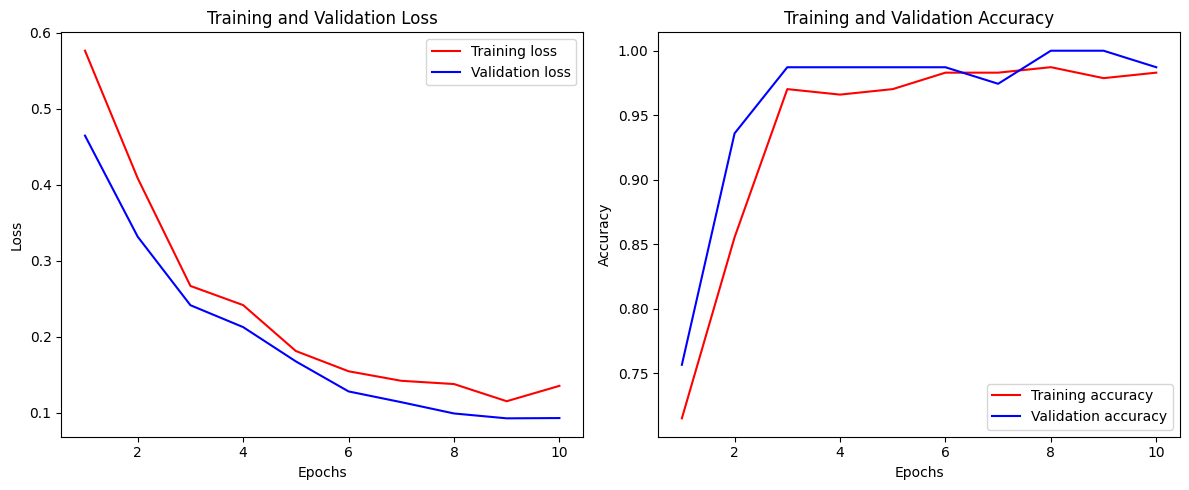

In [12]:
# Check if CUDA is available and set the device to GPU if it is, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model = resnet50.to(device)

# Define the number of epochs to train for and the patience for early stopping
num_epochs = 10
patience = 5

# Train the model and collect metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=resnet50, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
    val_loader=val_loader, num_epochs=num_epochs, patience=patience, device=device)

# Plot the collected metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


**Preparing the Test Set**

Evaluation Metrics and Confusion Matrix
We'll compute key metrics such as accuracy, precision, recall, and F1-score for the test set. Additionally, we'll generate a confusion matrix to visualize the model's performance across the different classes (`COVID` vs. `NORMAL`).

**Evaluation Mode:** Setting the model to evaluation mode (`model.eval()`) ensures that operations like dropout and batch normalization work in inference mode.

**Batch Processing:** The model processes each batch from the test set, and we accumulate the `true labels` and `predicted labels`.

**Binary Predictions:** Since we're dealing with a `binary classification` problem, we apply a `sigmoid function` to the model's outputs and round them to get binary predictions (`0` or `1`).

**Classification Report:** This provides a detailed analysis of the model's performance, including `precision`, `recall`, `F1-score`, and `accuracy` for each class.

**Confusion Matrix:** The `confusion matrix` visually represents the model's predictions, showing the `true positives`, `true negatives`, `false positives`, and `false negatives`. This is invaluable for understanding the model's strengths and weaknesses in classifying each category.

              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96        38
       COVID       1.00      0.93      0.96        41

    accuracy                           0.96        79
   macro avg       0.96      0.96      0.96        79
weighted avg       0.96      0.96      0.96        79



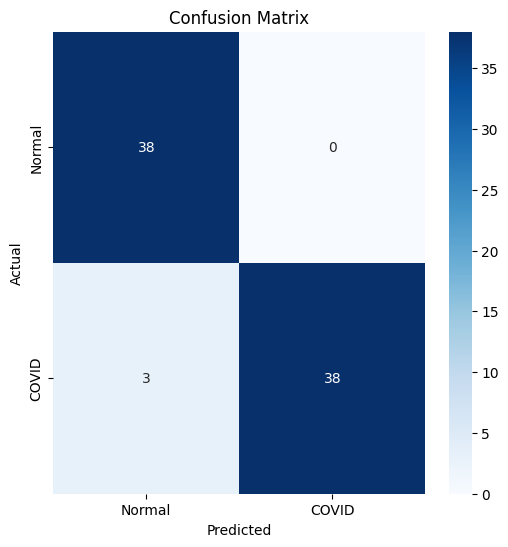

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs).round().cpu().numpy()  # Convert outputs to binary predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)
    
    # Calculate and print classification report
    print(classification_report(y_true, y_pred, target_names=['Normal', 'COVID']))
    
    # Generate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Normal', 'COVID'], yticklabels=['Normal', 'COVID'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function with the model, test_loader, and device
evaluate_model(model=resnet50, test_loader=test_loader, device=device)


### **Using Classic Machine learning Algorithms**

To apply a machine learning algorithm like Support Vector Machine (`SVM`) to our data for COVID diagnosis using lung scan images, we'll need to adapt the steps above for a machine learning context. This involves extracting features from the images, since SVMs and other traditional machine learning algorithms cannot directly process raw images like deep learning models. We'll leverage transfer learning for feature extraction using a pre-trained CNN, then train an SVM classifier on those features.

**Step 1: Feature Extraction with a Pre-trained Model**

First, use a pre-trained model (e.g., `ResNet50`) to extract features. We won't need the final classification layer, just the convolutional base.

In [14]:
import torchvision.models as models
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load a pre-trained ResNet50 model
feature_extraction_model = models.resnet50(pretrained=True)
# Remove the last layer (classifier) to use as a fixed feature extractor
feature_extraction_model = torch.nn.Sequential(*(list(feature_extraction_model.children())[:-1]))

# Set the model to evaluation mode
feature_extraction_model.eval()

# Assuming CUDA is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extraction_model.to(device);


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Step 2: Preprocess the Data**

Apply the necessary transformations to images. Make sure the transformations are compatible with the `pre-trained model's` requirements.

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define the path to your dataset
dataset_path = "../input/xray-image-dataset-for-covid19-detection-a/Dataset_A"
# Load your dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)


**Step 3: Extract Features**

Extract features for each image in the dataset. These features will serve as input for the `SVM`.

**Flatten Image Data for SVM**

We need to flatten each image into a one-dimensional vector that represents the raw pixel values. If images are already normalized and resized to a uniform size (as they should be, following our preprocessing steps), we can proceed as follows:

1. Iterate Over DataLoader: Extract the images and their labels.
2. Flatten Images: Convert each image tensor into a flattened vector.
3. Stack Vectors: Create a feature matrix where each row represents an image.

In [16]:
import torch

def extract_features_and_labels(dataloader):
    features = []
    labels = []
    
    for images, label_batch in dataloader:
        # Flatten the images; for grayscale images
        # For RGB images, you might need to adjust the view parameters
        flattened_images = images.view(images.size(0), -1)
        
        features.append(flattened_images)
        labels.append(label_batch)

    # Concatenate all the features and labels together
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features.numpy(), labels.numpy()

# Extract features and labels for train, validation, and test sets
X_train, y_train = extract_features_and_labels(train_loader)
X_val, y_val = extract_features_and_labels(val_loader)
X_test, y_test = extract_features_and_labels(test_loader)


In [17]:
print(f'Number of images for training: {len(X_train)} | Number of labels for training: {len(y_train)}')
print(f'Number of images for validation: {len(X_val)} | Number of labels for validation: {len(y_val)}')
print(f'Number of images for testing: {len(X_test)} | Number of labels for testing: {len(y_test)}')

Number of images for training: 235 | Number of labels for training: 235
Number of images for validation: 78 | Number of labels for validation: 78
Number of images for testing: 79 | Number of labels for testing: 79


**Training the SVM Classifier**

**1. Preprocessing:** Standardize the features since SVMs are sensitive to the scale of the input data.

**2. Hyperparameter Tuning:** Optionally, use cross-validation to find the best hyperparameters (C, kernel, gamma for RBF kernel, etc.).

**3. Training:** Train the SVM classifier using the training data.

**4. Validation:** Evaluate the model on the validation set to adjust hyperparameters if necessary.

**5. Testing:** Finally, test the model on the test set to assess its generalization ability.

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Preprocessing - Create a pipeline that first standardizes the data then trains an SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('svm', SVC(kernel='linear'))  # Use a linear kernel
])

# Step 2: Training - Fit the model to the training data
svm_pipeline.fit(X_train, y_train)

# Step 3: Validation (Optional) - Evaluate on the validation set
# Adjust hyperparameters as needed based on performance
y_val_pred = svm_pipeline.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Step 4: Testing - Evaluate the model on the test set
y_test_pred = svm_pipeline.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

# Print accuracy for a quick overview
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Validation Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        35

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        41

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

Test Accuracy: 1.0000


**Validation Set Tuning with GridSearchCV**

`GridSearchCV` systematically works through multiple combinations of parameter ranges, cross-validates the results to find the best combination of parameters. This helps in identifying the most effective SVM model.

* Parameter Grid: The `parameter_grid` might need adjustments based on your dataset and the specificities of the problem you're tackling. The ranges and values for C and gamma, and the choice of kernels, can significantly influence model performance.
* Scoring Metric: While this example uses accuracy as the scoring metric, consider other metrics like F1-score, especially if dealing with imbalanced classes. You can specify the metric in the `GridSearchCV` constructor with the `scoring parameter`.
* Model Complexity: Higher values of `C` and `gamma` can lead to more complex models, which might fit the training data better but can also cause overfitting. Always validate model choices using a held-out set (validation set) and, ultimately, the test set.
* Parallel Processing: The `n_jobs=-1` parameter in `GridSearchCV` enables the use of all CPU cores for parallel processing, speeding up the grid search. Adjust this based on your system's capabilities and workload requirements.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a pipeline combining a standard scaler and SVM classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Set the parameters to try out
parameter_grid = {
    'svm__C': [0.1, 1, 10, 100],  # Example C values; adjust based on your dataset
    'svm__kernel': ['linear', 'rbf'],  # Example kernels; consider others like 'poly'
    'svm__gamma': ['scale', 'auto']  # For RBF kernel; 'scale' is usually a good default
}

# Create a GridSearchCV object with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, parameter_grid, n_jobs=-1, verbose=3, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

# Use the best model found by GridSearchCV on the validation set
y_val_pred = grid_search.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:
{'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Validation Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        35

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



**Testing Set Evaluation**

After identifying the best model configuration using the validation set, evaluate the model's performance on the test set to understand its generalization ability. This step uses the best estimator found by GridSearchCV.

In [20]:
# Evaluate the best model found by GridSearchCV on the test set
y_test_pred = grid_search.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

# Calculate and print accuracy for a concise overview
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        41

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

Test Accuracy: 1.0000
